## Exploring the Data Provided by Quartix

# Data Format
* Categorised Data
    * 95 Examples, 16 Crashes, 79 Not Crashes
* Uncategorised Data
    * 406 Examples, unlabelled incidents
* Unlinked Data
    * Reduced amount of data on 6071 incidents

In [18]:
from extract_data import *
cat_data = get_data('data/categorised.json')
save_list(cat_data, 'pickle_data', 'cat_data')
uncat_data = get_data('data/uncategorised.json')
save_list(uncat_data, 'pickle_data', 'uncat_data')
#unlinked_data = get_data('Data/unlinked.json')
#save_list(unlinked_data, 'pickle_data', 'unlinked_data')

100%|██████████| 406/406 [00:46<00:00,  8.68it/s]


In [19]:
from extract_data import *

# Import the code using pickle

cat_data = load_list('pickle_data', 'cat_data')
uncat_data = load_list('pickle_data', 'uncat_data')
#unlinked_data = load_list('pickle_data', 'unlinked_data')

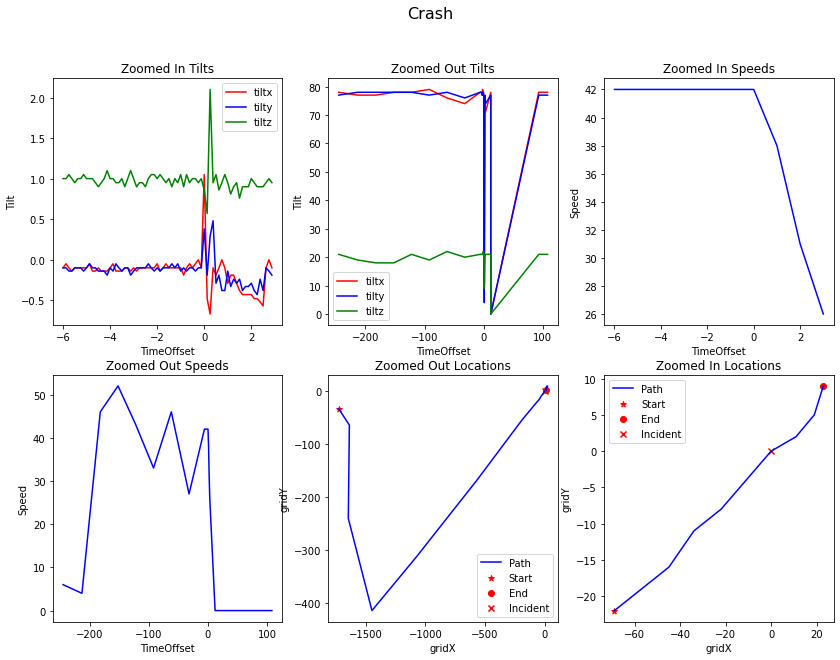

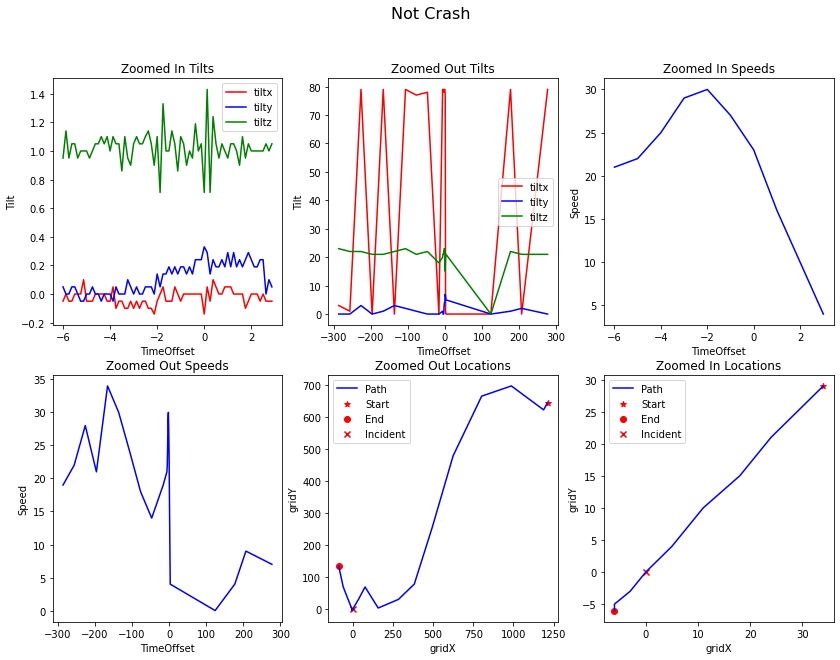

        event  timeoffset  speed  direction  gridx  gridy  tiltx  tilty  tiltz
8   CDistance          -6     42        250    -69    -22     78     78     21
9   CDistance          -5     42        255    -57    -19     78     78     21
10  CDistance          -4     42        250    -45    -16     78     78     21
11  CDistance          -3     42        250    -34    -11     78     77     21
13  CDistance          -2     42        250    -22     -8     79     78     21
14  CDistance          -1     42        250    -11     -4     78     77     22
15      Alert           0     42        245      0      0     78     77     22
16  CDistance           1     38        250     11      2     11      4      9
17  CDistance           2     31        255     19      5     74     77     20
18  CDistance           3     26        255     23      9     71     74     21


In [21]:
# Get example incident and plot

crash = cat_data[3]
not_crash = cat_data[30]
plot_example(crash, 'Crash')
plot_example(not_crash, 'Not Crash')
print(crash[0])

# Data Format
On calling get_data (or loading the lists using pickle) it returns a list of each incident. Each incident has 4 objects.

## Data[0]
This is the 'zoomed in' data from -6 seconds to +3 seconds. This includes speed and direction.

These data are also in Data[2].

## Data[1]
This is the 8hz, high resolution tilt data from -6 seconds to +2.875 seconds.

## Data[2]
This is the 'zoomed out' data from the beginning of the recording, throught the incident to the end.

This includes events, speed, directions, grid references, tilts

unlinked_data does not contain this.

## Data[3]
This is the status of the incident, i.e. whether it is a confirmed crash of not.

unlinked_data does not contain this.

## Accelerometer Data Analysis
Plotting many tilt against time graphs to get a gist for the data.

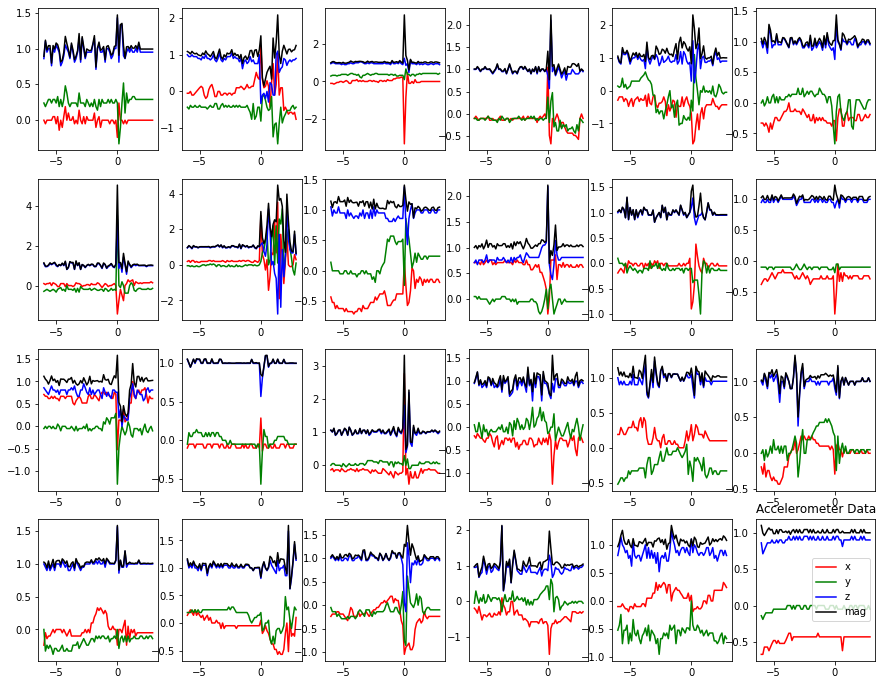

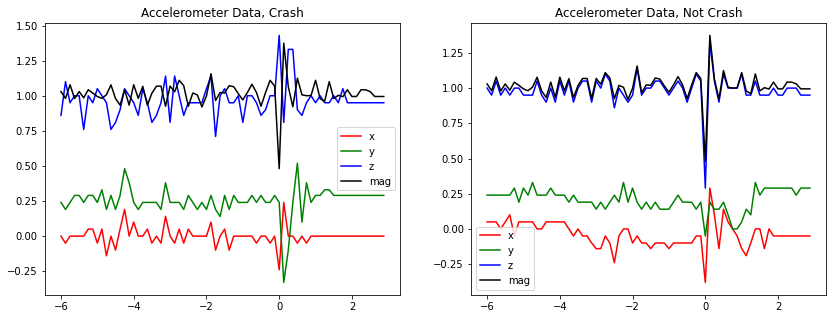

In [4]:
import random as rand

# Get the tilts for cat_data and plot an example crash and exameple not crash
crash_no = 0
no_crash_no = 40

all_tilts = get_tilt_timeseries(cat_data)
crash_tilts = all_tilts[crash_no,:,:]
no_crash_tilts = all_tilts[no_crash_no,:,:]
tilt_mags = get_mags(all_tilts)

colours = ['r','g','b']
labels = ['x','y','z']

timeoffset = np.linspace(-6,2.875,72)

fig=plt.figure(figsize=(15,12)), 
for k in range(24):
    plt.subplot(4,6,k+1)
    for i in range(3):
        plt.plot(timeoffset, all_tilts[k,:,i], c=colours[i], label = labels[i])
    plt.plot(timeoffset, tilt_mags[k], c='black', label='mag')
plt.legend(loc='best'), plt.title('Accelerometer Data') 
plt.show()

fig = plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
for i in range(3):
    plt.plot(timeoffset, crash_tilts[:,i], c=colours[i], label = labels[i])
plt.plot(timeoffset, tilt_mags[no_crash_no], c='black', label='mag')
plt.legend(loc='best'), plt.title('Accelerometer Data, Crash') 
plt.subplot(1,2,2)
for i in range(3):
    plt.plot(timeoffset, no_crash_tilts[:,i], c=colours[i], label = labels[i])
plt.plot(timeoffset, tilt_mags[no_crash_no], c='black', label='mag')
plt.legend(loc='best'), plt.title('Accelerometer Data, Not Crash') 
plt.show()

## PCA on Tilt Magnitudes

60 components explain 0.9525316446818398 percent of the data


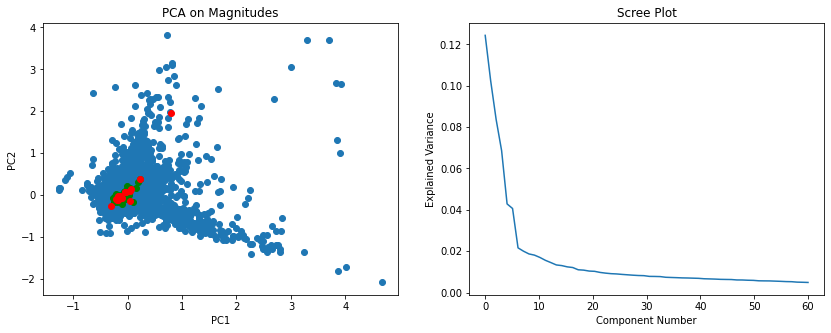

In [5]:
from sklearn.decomposition import PCA

# Get unlinked tilts
all_tilts = get_tilt_timeseries(unlinked_data)
#all_tilts = calibrate_tilts(all_tilts)
all_mags = get_mags(all_tilts)

# Get labelled tilts
test_tilts = get_tilt_timeseries(cat_data)
#test_tilts = calibrate_tilts(test_tilts)
test_mags = get_mags(test_tilts)
labels = np.array(get_labels(cat_data))
crash_ref = labels.nonzero()
nocrash_refs = (-1*(labels-1)).nonzero()

# Init PCA
n_components = 60
pca = PCA(n_components=n_components)

pca_mags = pca.fit_transform(all_mags)
pca_test_mags = pca.transform(test_mags)

# Plotting
fig=plt.figure(figsize=(14,5)), plt.subplot(1,2,1)
plt.scatter(pca_mags[:,0], pca_mags[:,1])
plt.scatter(pca_test_mags[nocrash_refs, 0], pca_test_mags[nocrash_refs, 1], color='green')
plt.scatter(pca_test_mags[crash_ref, 0], pca_test_mags[crash_ref, 1], color='red')
plt.xlabel('PC1'), plt.ylabel('PC2'), plt.title('PCA on Magnitudes')
plt.subplot(1,2,2)
plt.plot(np.linspace(0,n_components,n_components), pca.explained_variance_ratio_)
plt.ylabel('Explained Variance'), plt.xlabel('Component Number'), plt.title('Scree Plot')

print(len(pca.explained_variance_ratio_),'components explain', sum(pca.explained_variance_ratio_), 'percent of the data')


## PCA on Individual Directions
This shows how there are outliers (the small clusters away from the main cluster along PC1).

These outliers are due to the accelerometers being oriented incorrectly or perhaps calibrated wrong.

By uncommenting the calibrate tilts line (make sure you run the next cell first) you can see the PCA once the outliers are hopefully removed.

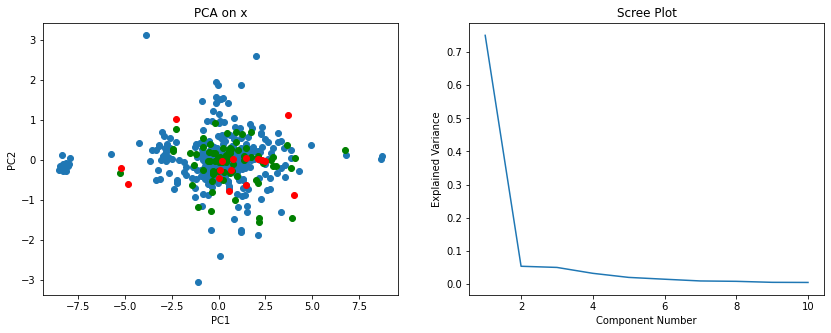

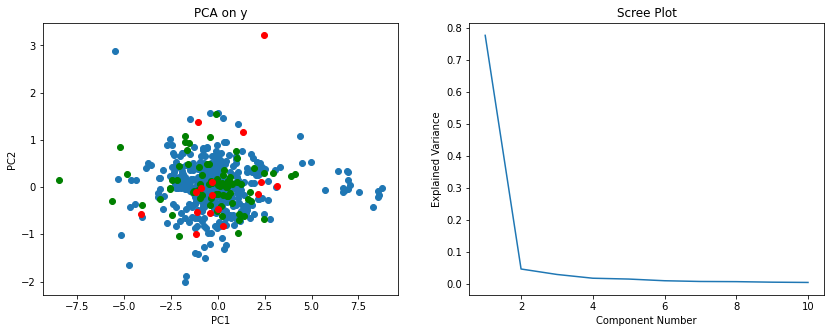

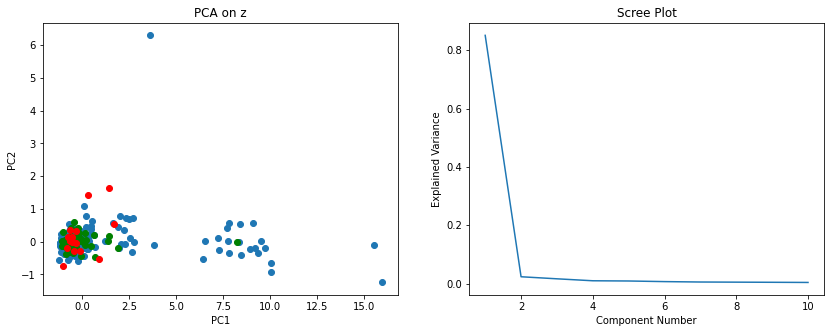

In [6]:
all_tilts = get_tilt_timeseries(uncat_data)
#all_tilts = calibrate_tilts(all_tilts)
x_tilts = all_tilts[:,:,0]
y_tilts = all_tilts[:,:,1]
z_tilts = all_tilts[:,:,2]
tilts = [x_tilts, y_tilts, z_tilts]

test_tilts = get_tilt_timeseries(cat_data)
#test_tilts = calibrate_tilts(all_tilts)
test_tilt_x = test_tilts[:,:,0]
test_tilt_y = test_tilts[:,:,1]
test_tilt_z = test_tilts[:,:,2]
test_tilts = [test_tilt_x, test_tilt_y, test_tilt_z]

dirs = ['x','y','z']

for i in range(3):
    # Init PCA
    n_components = 10
    pca = PCA(n_components=n_components)
    pca_tilts = pca.fit_transform(tilts[i])
    pca_test_tilts = pca.transform(test_tilts[i])

    # Plotting PC1/2 and scree plots
    fig=plt.figure(figsize=(14,5)), plt.subplot(1,2,1)
    plt.scatter(pca_tilts[:,0], pca_tilts[:,1])
    plt.xlabel('PC1'), plt.ylabel('PC2'), plt.title('PCA on '+  dirs[i])
    plt.scatter(pca_test_tilts[nocrash_refs, 0], pca_test_tilts[nocrash_refs, 1], color='green')
    plt.scatter(pca_test_tilts[crash_ref, 0], pca_test_tilts[crash_ref, 1], color='red')
    plt.subplot(1,2,2)
    plt.plot(np.linspace(1,n_components,n_components), pca.explained_variance_ratio_)
    plt.ylabel('Explained Variance'), plt.xlabel('Component Number'), plt.title('Scree Plot')

## Calibrating Accelerometer Data
Calculating the average acceleration for the first 4 seconds and then removing that from the whole time series to remove the effect of gravity.

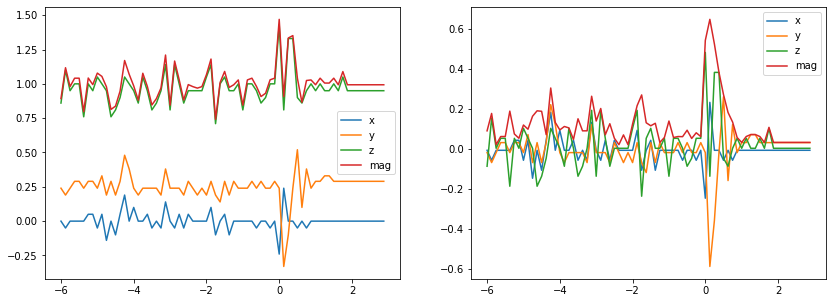

In [7]:
# Function to hopefully remove the effects of gravity and centre the data around 0
def calibrate_tilts(data):
    cali_data = np.empty(data.shape)
    for i in range(len(data)):
        # Calculate the average over the first 4 seconds (average shouldn't be affected by the crash)
        x_av = np.sum(data[i,:32,0])/len(data[i,:32,0])
        y_av = np.sum(data[i,:32,1])/len(data[i,:32,1])
        z_av = np.sum(data[i,:32,2])/len(data[i,:32,2])
        # Remove that average to centre the data
        cali_data[i,:,0] = data[i,:,0] - x_av
        cali_data[i,:,1] = data[i,:,1] - y_av
        cali_data[i,:,2] = data[i,:,2] - z_av
    return cali_data

# Get tilts and calibrate
tilts = get_tilt_timeseries(cat_data)
cali_tilts = calibrate_tilts(tilts)
tilt_mags = get_mags(tilts)
cali_mags = get_mags(cali_tilts)

incident_no = 0

# Plotting
fig = plt.figure(figsize=(14,5)), plt.subplot(1,2,1)
plt.plot(timeoffset, tilts[incident_no,:,0], label='x')
plt.plot(timeoffset, tilts[incident_no,:,1], label='y')
plt.plot(timeoffset, tilts[incident_no,:,2], label='z')
plt.plot(timeoffset, tilt_mags[incident_no,:], label='mag')
plt.legend()
plt.subplot(1,2,2)
plt.plot(timeoffset, cali_tilts[incident_no,:,0], label='x')
plt.plot(timeoffset, cali_tilts[incident_no,:,1], label='y')
plt.plot(timeoffset, cali_tilts[incident_no,:,2], label='z')
plt.plot(timeoffset, cali_mags[incident_no,:], label='mag')
plt.legend()
plt.show()


## Scaling the Data to Reduce the Effect of Outliers
Experimenting with different scalers to see how they affect the data.

Perhaps one can be used to centre the ztilts around 0 rather than 1 or -1 due to gravity.

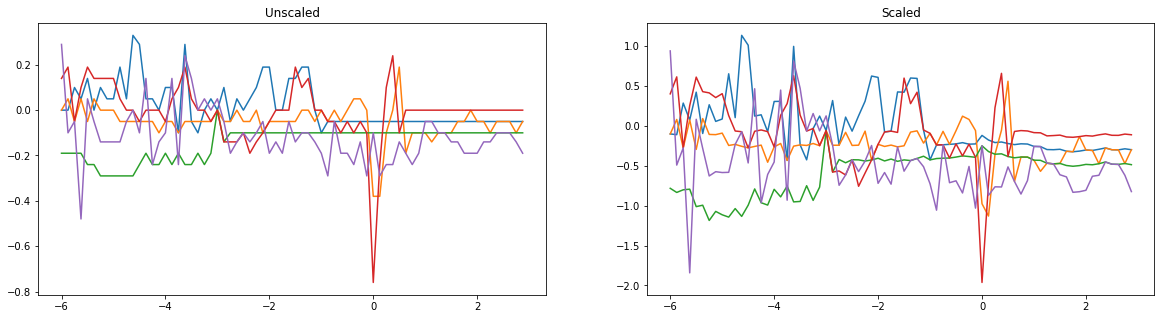

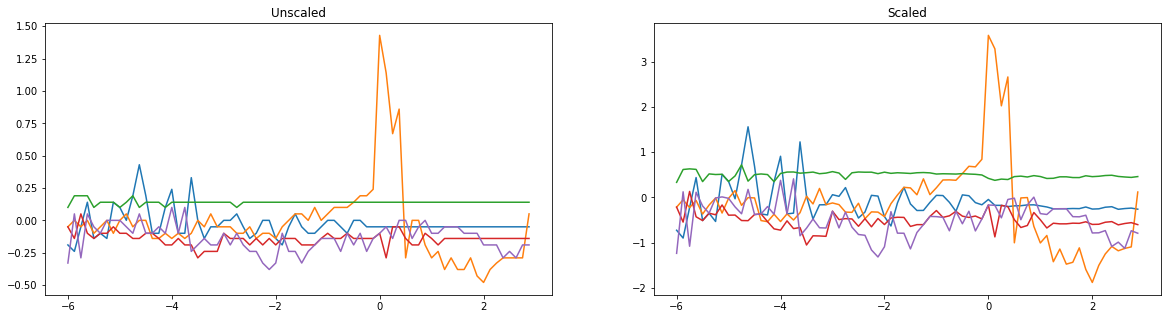

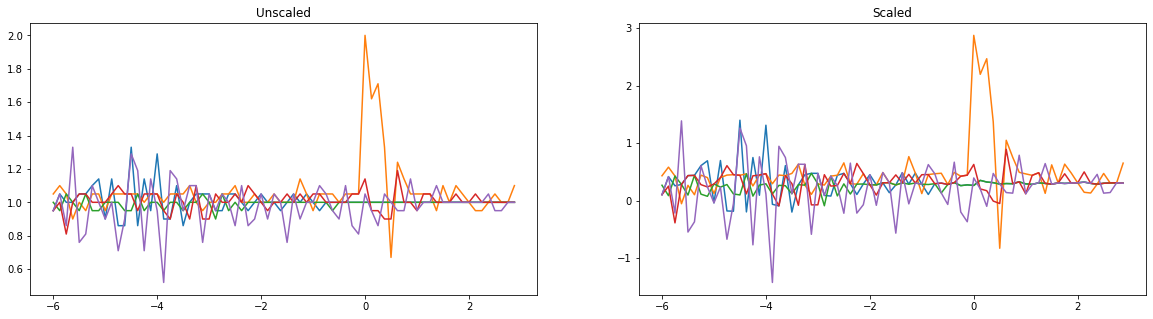

In [8]:
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler

# Get the Data
train_tilts = get_tilt_timeseries(uncat_data)
scaled_tilts = train_tilts

# Init scalers
r_scaler_x = StandardScaler()
r_scaler_y = StandardScaler()
r_scaler_z = StandardScaler()

# Fit the scaler for each axis
scaled_tilts[:,:,0] = r_scaler_x.fit_transform(X = scaled_tilts[:,:,0])
scaled_tilts[:,:,1] = r_scaler_y.fit_transform(X = scaled_tilts[:,:,1])
scaled_tilts[:,:,2] = r_scaler_z.fit_transform(X = scaled_tilts[:,:,2])

# Plot tilts to see effect of scaling
train_tilts = get_tilt_timeseries(uncat_data)
for a in range(3):
    plt.figure(figsize=(20,5))
    plt.subplot(1,2,1)
    for i in range(5):
        plt.plot(timeoffset, train_tilts[i,:,a], label='Unscaled')
    plt.title('Unscaled')
    plt.subplot(1,2,2)
    for i in range(5):
        plt.plot(timeoffset, scaled_tilts[i,:,a], label='Scaled')
    plt.title('Scaled')
    plt.show()


## Finite Response Filtering ???

## Clustering Using TimeSeriesKMeans and Acceleration Magnitude
Since the z-direction contains the most mis-oriented accelerometers and is affected by gravity I tried removing that axis and calculating the magnitude of acceleration only in the horizontal plane.
 - this is now redundant since the tilt data is being calibrated (z is being included)

PCA is used to visualise the data in 2D.

The inertia is used with an elbow plot to find the optimal number of clusters.

KMeans is used with DTW on the magnitudes in the horizontal plane.

There are still outliers as some mis-oriented boxes will have some axes swapped (x and z or y and z) therefore making the magnitude dominated by one of the directions.
- again, redundant due to calibration

Takes a long time to run when fitting on the unlinked data.

C:\Users\chris\anaconda3\envs\MDMvenv\lib\site-packages\tslearn\clustering\kmeans.py:16: UserWarning: Scikit-learn <0.24 will be deprecated in a future release of tslearn
  warnings.warn(


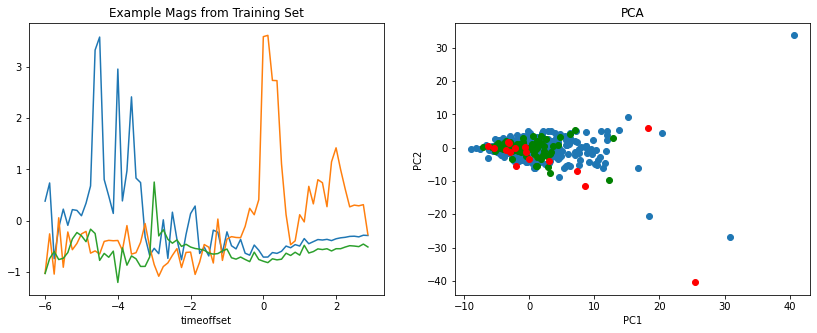

Explained Variances: [0.37889515 0.14535514 0.07110845 0.03839269]


C:\Users\chris\anaconda3\envs\MDMvenv\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 95 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


Accuracy: 0.43157894736842106
[[29 37  2 11  0]
 [ 3  7  1  4  1]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]]
Inertia(n= 5 ): 15.706079054174314


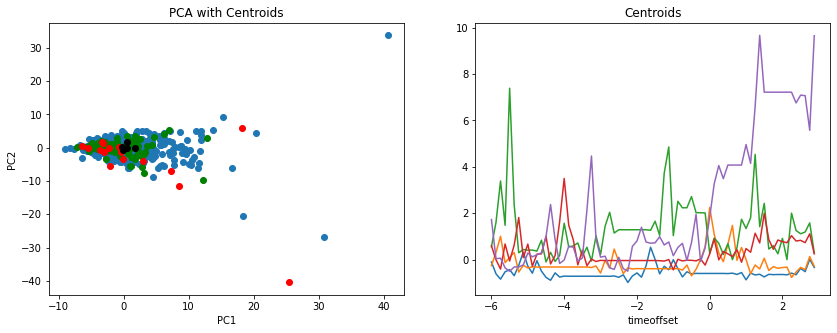

In [9]:
from tslearn.clustering import TimeSeriesKMeans, KernelKMeans, KShape
from metrics import *
from sklearn.metrics import confusion_matrix

# Attempt at clustering magnitude computed using all three directions

scaler = StandardScaler()

train_tilts = get_tilt_timeseries(uncat_data)
train_tilts = calibrate_tilts(train_tilts) # Using new calibration
train_mags = get_mags(train_tilts)
train_mags = scaler.fit_transform(train_mags) # Scaling

test_tilts = get_tilt_timeseries(cat_data)
test_tilts = calibrate_tilts(test_tilts) # Using new calibration
test_mags = get_mags(test_tilts)
test_mags = scaler.transform(test_mags) # Scaling
y = get_labels(cat_data)

# Compute PCA for visualisations
pca = PCA(n_components=4)
pca.fit(train_mags)
train_mags_pca = pca.transform(train_mags)
test_mags_pca = pca.transform(test_mags)

fig = plt.figure(figsize=(14,5)), plt.subplot(1,2,1)
# PLot 3 examples from training set
for i in range(3):
    plt.plot(timeoffset, train_mags[i,:])
plt.title('Example Mags from Training Set'), plt.xlabel('timeoffset')
# Plot PCA on training/test set
plt.subplot(1,2,2)
plt.scatter(train_mags_pca[:,0], train_mags_pca[:,1])
plt.scatter(test_mags_pca[nocrash_refs,0], test_mags_pca[nocrash_refs,1], c='green')
plt.scatter(test_mags_pca[crash_ref,0], test_mags_pca[crash_ref,1], c='red')
plt.title('PCA'), plt.xlabel('PC1'), plt.ylabel('PC2')
plt.show()
print('Explained Variances:', pca.explained_variance_ratio_)

'''
# Finding optimal number of clusters
inertias = []
for n in range(2,10):
    km = TimeSeriesKMeans(n, metric='dtw', dtw_inertia=True)
    km.fit(train_mags)
    inertias.append(km.inertia_)
print('Inertias:', inertias)
plt.plot(range(2,10), inertias)
plt.title('Elbow Plot Of Inertias'), plt.xlabel('K'), plt.ylabel('Inertia')
plt.show()
'''

# Run KMeans with DTW
n_clusters = 5
km = TimeSeriesKMeans(n_clusters, metric='dtw', dtw_inertia=True)
#km = KShape(n_clusters)
km.fit(train_mags)
y_pred = km.predict(test_mags)
print('Accuracy:', acc(np.array(y), np.array(y_pred)))
print(confusion_matrix(y, y_pred))
centroids = km.cluster_centers_
centroids = np.reshape(centroids, (n_clusters,72))
print('Inertia(n=',n_clusters,'):', km.inertia_)

# Transfrom centroids into PCA space
centroids_pca = pca.transform(centroids)

# Plot PC1/2
fig = plt.figure(figsize=(14,5)), plt.subplot(1,2,1)
plt.scatter(train_mags_pca[:,0], train_mags_pca[:,1])
plt.scatter(test_mags_pca[nocrash_refs,0], test_mags_pca[nocrash_refs,1], c='green')
plt.scatter(test_mags_pca[crash_ref,0], test_mags_pca[crash_ref,1], c='red')
plt.scatter(centroids[:,0], centroids[:,1], c='black')
plt.title('PCA with Centroids'), plt.xlabel('PC1'), plt.ylabel('PC2')
# Plot centroid PCs
plt.subplot(1,2,2)
for i in range(n_clusters):
    plt.plot(timeoffset, centroids[i,:])
plt.title('Centroids'), plt.xlabel('timeoffset')
plt.show()

## Clustering Using Multivariate Time Series (x,y,z)
Using the TimeSeriesKMeans to produce centroids that have 3 dimensions. Like above but without calculating the magnitude of the accelerations.

Up to ~70% accuracy.

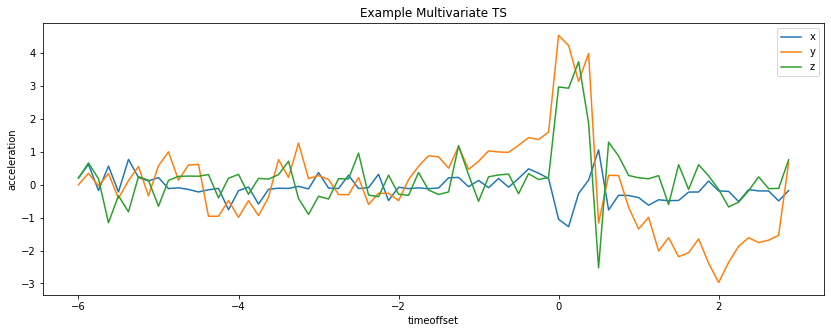

Inertias: [152.7597452473311, 150.94771008596027, 136.8945600280324, 139.05888060791096, 130.3529371008819, 119.69436728897499, 118.52693485212731, 119.83677427505943]


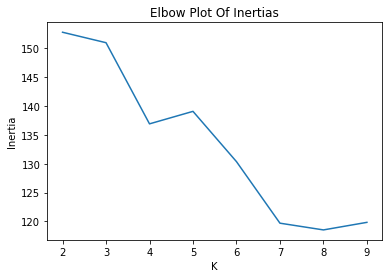

Accuracy: 0.7157894736842105
[[10  0 62  7]
 [ 6  1  6  3]
 [ 0  0  0  0]
 [ 0  0  0  0]]
centroids shape: (4, 72, 3)
Inertia(n= 4 ): 138.4978556241095


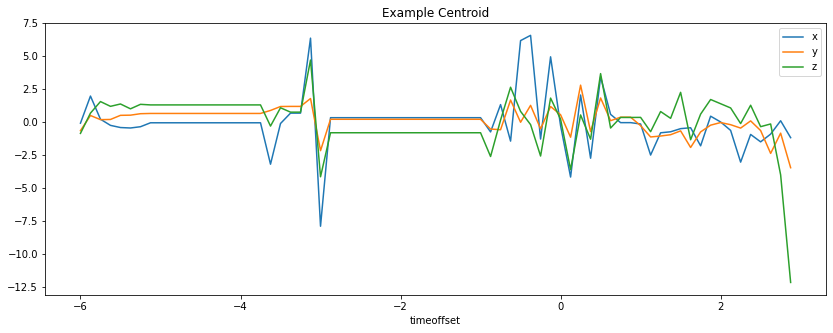

In [31]:
# Attempt at clustering multivariate time series

train_tilts = get_tilt_timeseries(uncat_data)
train_tilts = calibrate_tilts(train_tilts) # Using new calibration
train_tilts[:,:,0] = r_scaler_x.fit_transform(train_tilts[:,:,0])
train_tilts[:,:,1] = r_scaler_y.fit_transform(train_tilts[:,:,1])
train_tilts[:,:,2] = r_scaler_z.fit_transform(train_tilts[:,:,2])

test_tilts = get_tilt_timeseries(cat_data)
test_tilts = calibrate_tilts(test_tilts) # Using new calibration
test_tilts[:,:,0] = r_scaler_x.transform(test_tilts[:,:,0])
test_tilts[:,:,1] = r_scaler_y.transform(test_tilts[:,:,1])
test_tilts[:,:,2] = r_scaler_z.transform(test_tilts[:,:,2])
y = get_labels(cat_data)

dirs = ['x', 'y', 'z']

fig = plt.figure(figsize=(14,5))
# PLot 3 examples from training set
for i in range(3):
    plt.plot(timeoffset, train_tilts[1,:,i], label = dirs[i])
plt.title('Example Multivariate TS'), plt.xlabel('timeoffset'), plt.ylabel('acceleration'), plt.legend()
plt.show()


# Finding optimal number of clusters
inertias = []
for n in range(2,10):
    km = TimeSeriesKMeans(n, metric='dtw', dtw_inertia=True)
    km.fit(train_tilts)
    inertias.append(km.inertia_)
print('Inertias:', inertias)
plt.plot(range(2,10), inertias)
plt.title('Elbow Plot Of Inertias'), plt.xlabel('K'), plt.ylabel('Inertia')
plt.show()


# Run KMeans with DTW
n_clusters = 4
km = TimeSeriesKMeans(n_clusters, metric='dtw', dtw_inertia=True)
#km = KShape(n_clusters)
km.fit(train_tilts)
y_pred = km.predict(test_tilts)
print('Accuracy:', acc(np.array(y), np.array(y_pred)))
print(confusion_matrix(y, y_pred))
centroids = km.cluster_centers_
print('centroids shape:', centroids.shape)
#centroids = np.reshape(centroids, (n_clusters,72))
print('Inertia(n=',n_clusters,'):', km.inertia_)

# Plot Example, multivariate centroid
fig=plt.figure(figsize=(14,5))
for i in range(3):
    plt.plot(timeoffset, centroids[1,:,i], label = dirs[i])
plt.title('Example Centroid'), plt.xlabel('timeoffset'), plt.legend()
plt.show()

## Normal K-means on the PCA data
Not any more effective than TimeSeriesKMeans using DTW

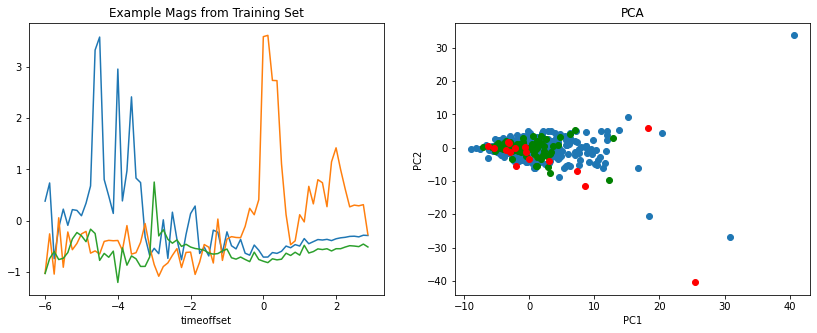

Explained Variances: [0.37889515 0.14535514 0.07110845 0.03839269]
Inertias: [12091.538605760556, 9504.283004942401, 7769.135180556759, 6037.814491492214, 5156.8469023240505, 4645.55004928947, 4233.236184086335, 3867.78290659098]
Accuracy: 0.5052631578947369
[[44  4 31  0]
 [ 8  3  4  1]
 [ 0  0  0  0]
 [ 0  0  0  0]]
Inertia(n= 5 ): 6037.616083242576


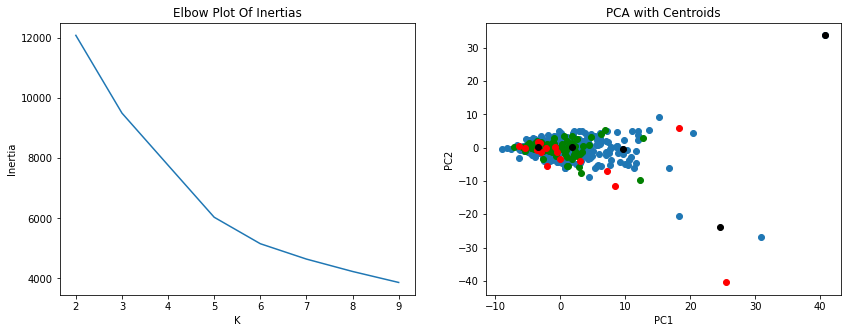

(Text(0.5, 1.0, 'PCA with Centroids'),
 Text(0.5, 17.200000000000003, 'PC1'),
 Text(453.8090909090908, 0.5, 'PC2'),
 None)

In [32]:
from sklearn.cluster import KMeans
from metrics import *
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Attempt at clustering based on PCA values from the acceleration magnitudes

train_tilts = get_tilt_timeseries(uncat_data)
train_tilts = calibrate_tilts(train_tilts) # Using new calibration
train_mags = get_mags(train_tilts)
train_mags = scaler.fit_transform(train_mags)

test_tilts = get_tilt_timeseries(cat_data)
test_tilts = calibrate_tilts(test_tilts) # Using new calibration
test_mags = get_mags(test_tilts)
test_mags = scaler.transform(test_mags)
y = get_labels(cat_data)

# Compute PCA for visualisations
pca = PCA(n_components=4)
pca.fit(train_mags)
train_mags_pca = pca.transform(train_mags)
test_mags_pca = pca.transform(test_mags)

fig = plt.figure(figsize=(14,5)), plt.subplot(1,2,1)
# PLot 3 examples from training set
for i in range(3):
    plt.plot(timeoffset, train_mags[i,:])
plt.title('Example Mags from Training Set'), plt.xlabel('timeoffset')
# Plot PCA on training/test set
plt.subplot(1,2,2)
plt.scatter(train_mags_pca[:,0], train_mags_pca[:,1])
plt.scatter(test_mags_pca[nocrash_refs,0], test_mags_pca[nocrash_refs,1], c='green')
plt.scatter(test_mags_pca[crash_ref,0], test_mags_pca[crash_ref,1], c='red')
plt.title('PCA'), plt.xlabel('PC1'), plt.ylabel('PC2')
plt.show()
print('Explained Variances:', pca.explained_variance_ratio_)

# Find optimal number of clusters
inertias = []
for n in range(2,10):
    km = KMeans(n)
    km.fit(train_mags_pca)
    inertias.append(km.inertia_)
print('Inertias:', inertias)
plt.figure(figsize=(14,5)), plt.subplot(1,2,1)
plt.plot(range(2,10), inertias)
plt.title('Elbow Plot Of Inertias'), plt.xlabel('K'), plt.ylabel('Inertia')


# Run KMeans with on PCA space
n_clusters = 5
km = KMeans(n_clusters)
#km = KShape(n_clusters)
km.fit(train_mags_pca)
y_pred = km.predict(test_mags_pca)
print('Accuracy:', acc(np.array(y), np.array(y_pred)))
print(confusion_matrix(y, y_pred))
centroids = km.cluster_centers_
print('Inertia(n=',n_clusters,'):', km.inertia_)

# Plot PC1/2
plt.subplot(1,2,2)
plt.scatter(train_mags_pca[:,0], train_mags_pca[:,1])
plt.scatter(test_mags_pca[nocrash_refs,0], test_mags_pca[nocrash_refs,1], c='green')
plt.scatter(test_mags_pca[crash_ref,0], test_mags_pca[crash_ref,1], c='red')
plt.scatter(centroids[:,0], centroids[:,1], c='black')
plt.title('PCA with Centroids'), plt.xlabel('PC1'), plt.ylabel('PC2'), plt.show()


## Calibrating and Removing Z Direction for Clustering in Horizontal Plane

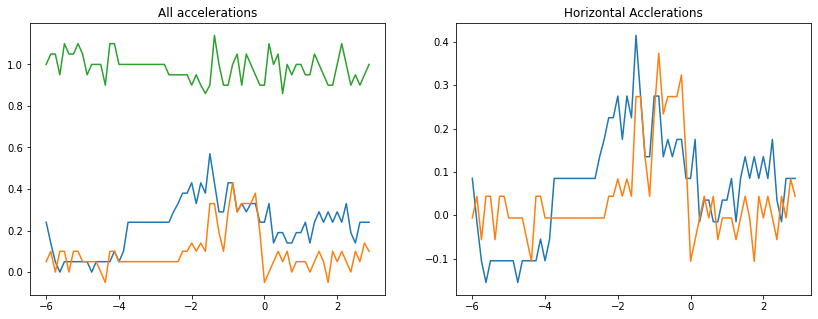

In [33]:
# Function to hopefully remove the effects of gravity and centre the data around 0
def calibrate_remove_z(data):
    cali_data = np.empty((int(data.shape[0]), int(data.shape[1]), 2))
    z_dirs = []
    for i in range(len(data)):
        # Calculate the average over the first 4 seconds (average shouldn't be affected by the crash)
        x_av = np.sum(data[i,:32,0])/len(data[i,:32,0])
        y_av = np.sum(data[i,:32,1])/len(data[i,:32,1])
        z_av = np.sum(data[i,:32,2])/len(data[i,:32,2])

        max_av = np.argmax(np.abs([x_av, y_av, z_av])) # find the direction with largest absolute value (should be z)
        z_dirs.append(max_av)

        if max_av == 0:
            cali_data[i,:,0] = data[i,:,1] - y_av
            cali_data[i,:,1] = data[i,:,2] - z_av
        if max_av == 1:
            cali_data[i,:,0] = data[i,:,0] - x_av
            cali_data[i,:,1] = data[i,:,2] - z_av
        if max_av == 2:
            cali_data[i,:,0] = data[i,:,0] - x_av
            cali_data[i,:,1] = data[i,:,1] - y_av

    return cali_data

tilts = get_tilt_timeseries(uncat_data)
cali_tilts = calibrate_remove_z(tilts)

incident_no = 15

plt.figure(figsize=(14,5)), plt.subplot(1,2,1)
for i in range(3):
    plt.plot(timeoffset, tilts[incident_no,:,i])
plt.title('All accelerations')
plt.subplot(1,2,2)
for i in range(2):
    plt.plot(timeoffset, cali_tilts[incident_no,:,i])
plt.title('Horizontal Acclerations')
plt.show()

## Clustering in The Horizontal Plane
Similar to multivariate clustering above just using only 2 directions instead of all 3.

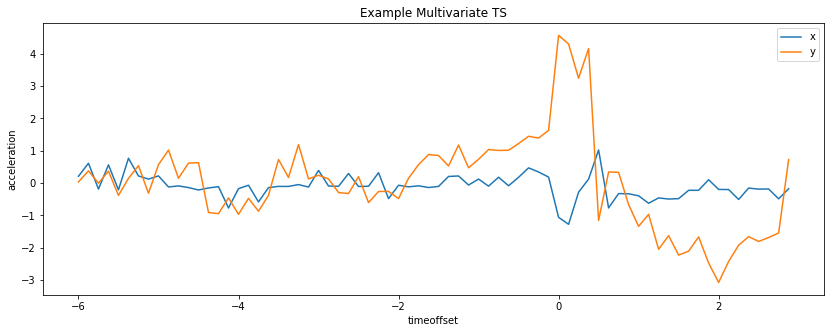

Accuracy: 0.43157894736842106
[[ 0 24  5 10  1 39]
 [ 0  1  2  0  2 11]
 [ 0  0  0  0  0  0]
 [ 0  0  0  0  0  0]
 [ 0  0  0  0  0  0]
 [ 0  0  0  0  0  0]]
centroids shape: (7, 72, 2)
Inertia(n= 7 ): 64.90814682271983


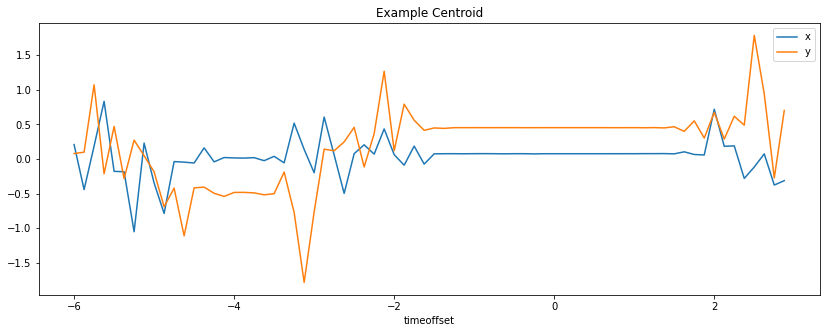

In [42]:
# Attempt at clustering multivariate time series only in horizontal plane

r_scaler_x = StandardScaler()
r_scaler_y = StandardScaler()

train_tilts = get_tilt_timeseries(uncat_data)
train_tilts = calibrate_remove_z(train_tilts) # Using new calibration + remove
train_tilts[:,:,0] = r_scaler_x.fit_transform(train_tilts[:,:,0])
train_tilts[:,:,1] = r_scaler_y.fit_transform(train_tilts[:,:,1])

test_tilts = get_tilt_timeseries(cat_data)
test_tilts = calibrate_remove_z(test_tilts) # Using new calibration + remove
test_tilts[:,:,0] = r_scaler_x.transform(test_tilts[:,:,0])
test_tilts[:,:,1] = r_scaler_y.transform(test_tilts[:,:,1])
y = get_labels(cat_data)

dirs = ['x', 'y', 'z']

fig = plt.figure(figsize=(14,5))
# PLot 3 examples from training set
for i in range(2):
    plt.plot(timeoffset, train_tilts[1,:,i], label = dirs[i])
plt.title('Example Multivariate TS'), plt.xlabel('timeoffset'), plt.ylabel('acceleration'), plt.legend()
plt.show()

'''
# Finding optimal number of clusters
inertias = []
for n in range(2,10):
    km = TimeSeriesKMeans(n, metric='dtw', dtw_inertia=True)
    km.fit(train_tilts)
    inertias.append(km.inertia_)
print('Inertias:', inertias)
plt.plot(range(2,10), inertias)
plt.title('Elbow Plot Of Inertias'), plt.xlabel('K'), plt.ylabel('Inertia')
plt.show()
'''

# Run KMeans with DTW
n_clusters = 7
km = TimeSeriesKMeans(n_clusters, metric='dtw', dtw_inertia=True)
#km = KShape(n_clusters)
km.fit(train_tilts)
y_pred = km.predict(test_tilts)
print('Accuracy:', acc(np.array(y), np.array(y_pred)))
print(confusion_matrix(y, y_pred))
centroids = km.cluster_centers_
print('centroids shape:', centroids.shape)
#centroids = np.reshape(centroids, (n_clusters,72))
print('Inertia(n=',n_clusters,'):', km.inertia_)

# Plot Example, multivariate centroid
fig=plt.figure(figsize=(14,5))
for i in range(2):
    plt.plot(timeoffset, centroids[1,:,i], label = dirs[i])
plt.title('Example Centroid'), plt.xlabel('timeoffset'), plt.legend()
plt.show()

## Clustering Using Magnitudes in the Horizontal Plane
Using the calibrate_remove_z function to identify and remove the z direction then get the magnitudes and cluster.

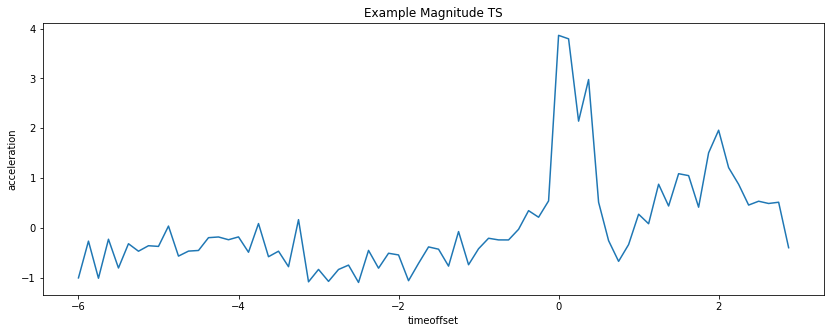

Accuracy: 0.5473684210526316
[[31 46  1  1]
 [ 6  6  2  2]
 [ 0  0  0  0]
 [ 0  0  0  0]]
centroids shape: (4, 72, 1)
Inertia(n= 4 ): 17.516317934277325


C:\Users\chris\anaconda3\envs\MDMvenv\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 95 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


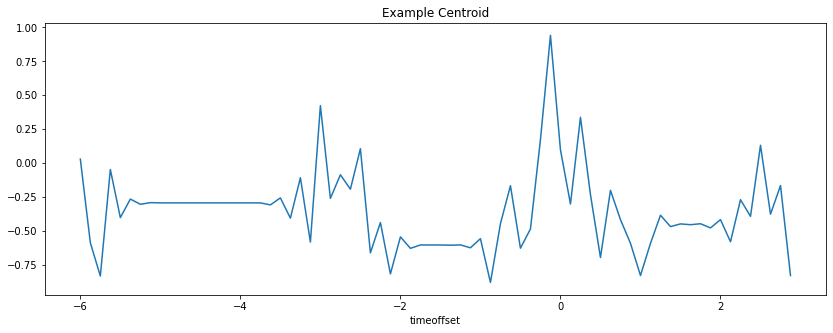

In [49]:
# Attempt at clustering magnitudes from the horizontal plane

scaler = StandardScaler()

train_tilts = get_tilt_timeseries(uncat_data)
train_tilts = calibrate_remove_z(train_tilts) # Using new calibration + remove
train_mags = get_mags(train_tilts)
train_mags = scaler.fit_transform(train_mags)

test_tilts = get_tilt_timeseries(cat_data)
test_tilts = calibrate_remove_z(test_tilts) # Using new calibration + remove
test_mags = get_mags(test_tilts)
test_mags = scaler.transform(test_mags)
y = get_labels(cat_data)

dirs = ['x', 'y', 'z']

fig = plt.figure(figsize=(14,5))
# PLot 3 examples from training set
plt.plot(timeoffset, train_mags[1,:])
plt.title('Example Magnitude TS'), plt.xlabel('timeoffset'), plt.ylabel('acceleration')
plt.show()

'''
# Finding optimal number of clusters
inertias = []
for n in range(2,10):
    km = TimeSeriesKMeans(n, metric='dtw', dtw_inertia=True)
    km.fit(train_mags)
    inertias.append(km.inertia_)
print('Inertias:', inertias)
plt.plot(range(2,10), inertias)
plt.title('Elbow Plot Of Inertias'), plt.xlabel('K'), plt.ylabel('Inertia')
plt.show()
'''

# Run KMeans with DTW
n_clusters = 4
km = TimeSeriesKMeans(n_clusters, metric='dtw', dtw_inertia=True)
#km = KShape(n_clusters)
km.fit(train_mags)
y_pred = km.predict(test_mags)
print('Accuracy:', acc(np.array(y), np.array(y_pred)))
print(confusion_matrix(y, y_pred))
centroids = km.cluster_centers_
print('centroids shape:', centroids.shape)
#centroids = np.reshape(centroids, (n_clusters,72))
print('Inertia(n=',n_clusters,'):', km.inertia_)

# Plot Example, multivariate centroid
fig=plt.figure(figsize=(14,5))
plt.plot(timeoffset, centroids[1,:], label = 'mag')
plt.title('Example Centroid'), plt.xlabel('timeoffset')
plt.show()

## Feature Extraction and PCA

(406, 14)


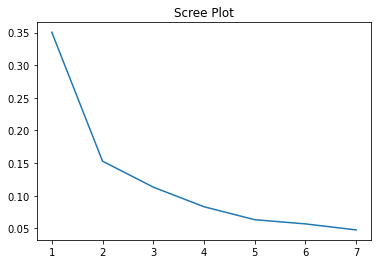

[0.35063538 0.1529752  0.11314958 0.08309289 0.06319626 0.05677192
 0.04753575]
Inertias: [4506.205258915251, 3906.203133680825, 3474.1222027978492, 3106.9862487634073, 2797.616174071307, 2577.2444090931604, 2458.413449467601, 2262.807988101844]


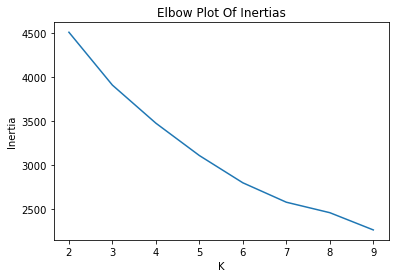

KMeans acc: 0.42105263157894735
kMeans conmat:
 [[16  9 20 34  0]
 [ 0  6  4  5  1]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]]


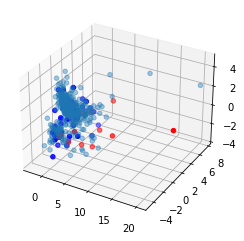

No handles with labels found to put in legend.


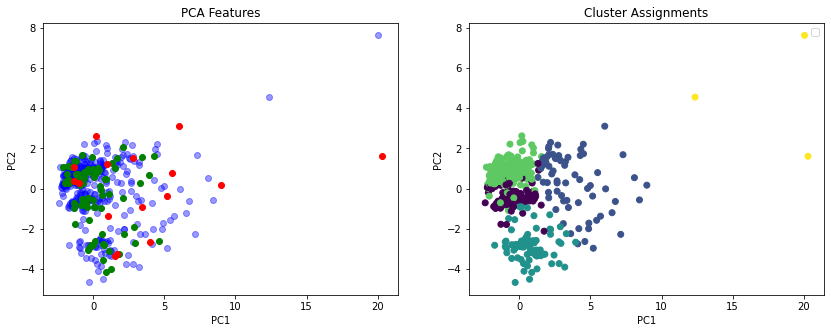

In [43]:
from feature_selection import *
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from metrics import *
from sklearn.metrics import confusion_matrix

# Init scaler
scaler = StandardScaler()

# Load data and labels
cat_data = load_list('pickle_data', 'cat_data')
uncat_data = load_list('pickle_data', 'uncat_data')
labels = np.array(get_labels(cat_data))

train_x = extract_features(uncat_data)
train_x = scaler.fit_transform(train_x)
print(train_x.shape)

# Get features from data and scale
test_x = extract_features(cat_data)
test_x = scaler.transform(test_x)

# Get crashes and not crashes for plotting
crash_ref = labels.nonzero()
no_crash_ref = ((labels -1)*(-1))
no_crash_ref = no_crash_ref.nonzero()

# Compute optimal number of components
pca = PCA(n_components=7)
train_pca = pca.fit_transform(train_x)
plt.plot(np.linspace(1,7,7), pca.explained_variance_ratio_), plt.title('Scree Plot')
plt.show()
print(pca.explained_variance_ratio_)
# Compute PCA for vis and clustering
pca = PCA(n_components=4)
train_pca = pca.fit_transform(train_x)
test_pca = pca.transform(test_x)


# Finding optimal number of clusters
inertias = []
for n in range(2,10):
    km = KMeans(n)
    km.fit(train_x)
    inertias.append(km.inertia_)
print('Inertias:', inertias)
plt.plot(range(2,10), inertias)
plt.title('Elbow Plot Of Inertias'), plt.xlabel('K'), plt.ylabel('Inertia')
plt.show()

# K-Means Clustering 
km = KMeans(n_clusters=5)
km.fit(train_x)
y_pred = km.predict(test_x)

print('KMeans acc:', acc(y_pred, labels))
print('kMeans conmat:\n',confusion_matrix(labels, y_pred))

# Plotting
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(train_pca[:,0], train_pca[:,1], train_pca[:,2], alpha=0.4)
ax.scatter(test_pca[crash_ref,0], test_pca[crash_ref,1], test_pca[crash_ref,2], c='red')
ax.scatter(test_pca[no_crash_ref,0], test_pca[no_crash_ref,1], test_pca[no_crash_ref,2], c='blue')
plt.show()

fig = plt.figure(figsize=(14,5)), plt.subplot(1,2,1)
plt.scatter(train_pca[:,0], train_pca[:,1], c='b', alpha=0.4)
plt.scatter(test_pca[no_crash_ref,0], test_pca[no_crash_ref,1], c='g')
plt.scatter(test_pca[crash_ref,0], test_pca[crash_ref,1], c='red')
plt.title('PCA Features'), plt.xlabel('PC1'), plt.ylabel('PC2')
plt.subplot(1,2,2)
plt.scatter(train_pca[:,0], train_pca[:,1], c=km.labels_.astype(float))
plt.scatter(test_pca[:,0], test_pca[:,1], c=y_pred.astype(float))
plt.title('Cluster Assignments'), plt.xlabel('PC1'), plt.ylabel('PC2')
plt.legend()
plt.show()



## Plotting Members of Clusters

[3 2 1 3 1 2 1 4 1 2 3 3 1 3 1 3 3 1 3 1 1 1 2 3 0 3 3 3 0 3 2 0 3 2 2 3 0
 3 0 0 3 0 3 1 0 1 2 3 2 3 0 2 3 3 3 1 3 2 3 2 2 2 2 3 1 3 3 0 2 3 3 0 2 3
 2 3 2 3 3 3 3 3 0 0 0 0 2 2 3 2 2 3 0 1 2]
(16, 72, 2)
[[24 28 31 36 38 39 41 44 50 67 71 82 83 84 85 92]]


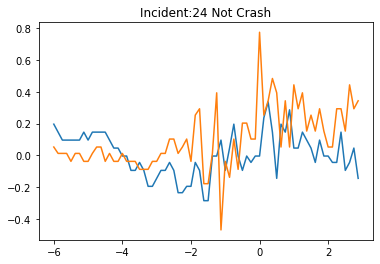

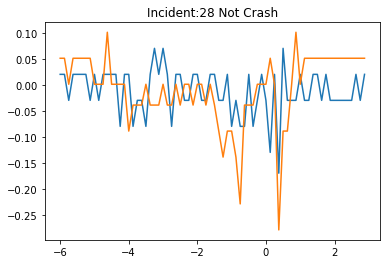

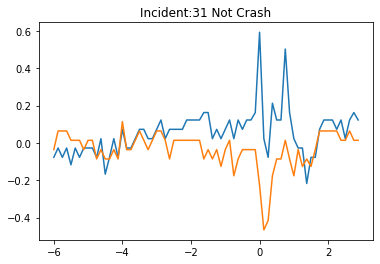

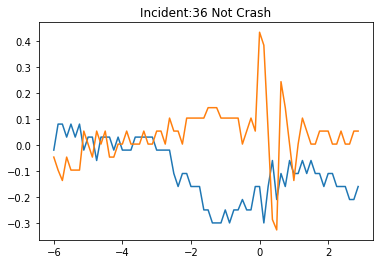

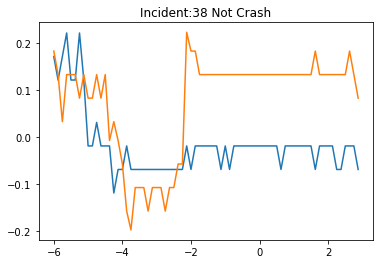

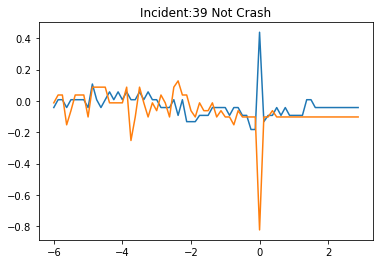

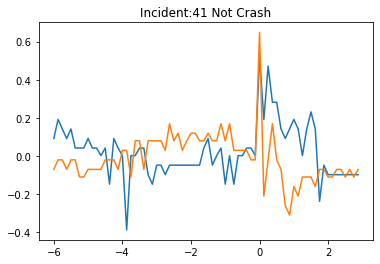

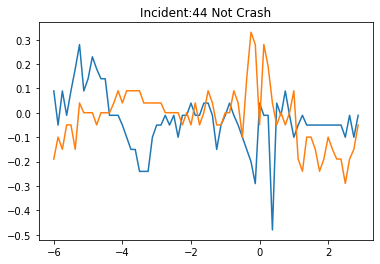

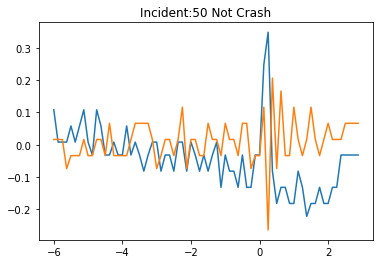

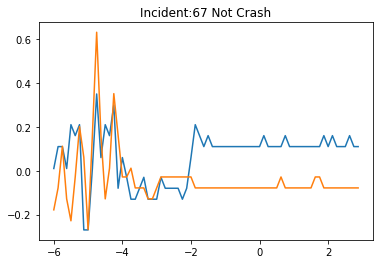

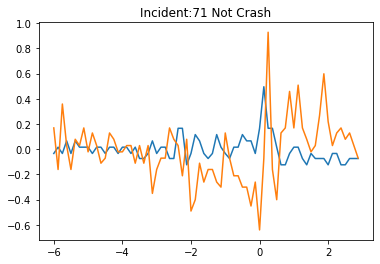

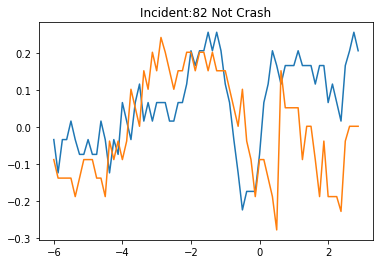

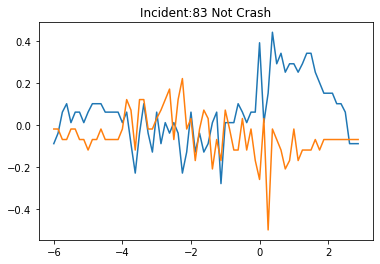

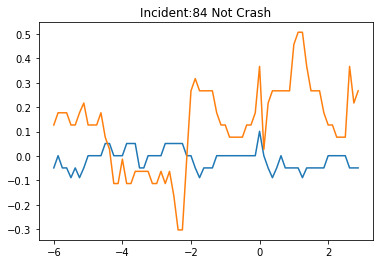

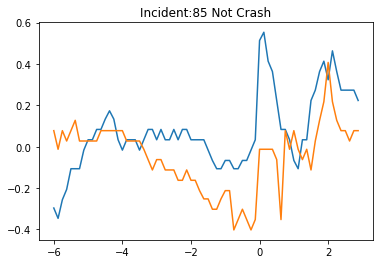

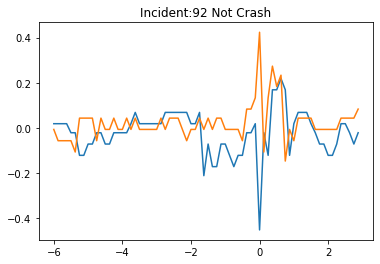

In [45]:
print(y_pred)
# Get members of a certain cluster
cluster = np.where(y_pred==0)

# Get tilts
tilts = get_tilt_timeseries(cat_data)
tilts = calibrate_remove_z(tilts)

tilts = tilts[cluster]
timeoffset = np.linspace(-6,2.875,72)
print(tilts.shape)

cluster = np.array(cluster)
crash_ref = np.array(crash_ref)
print(cluster)

# Plot tilts
for i in range(tilts.shape[0]):
    #plt.subplot(1, tilts.shape[0], i+1)
    plt.plot(timeoffset, tilts[i,:,0])
    plt.plot(timeoffset, tilts[i,:,1])
    if cluster[0,i] in crash_ref:
        plt.title('Incident:' + str(cluster[0,i]) + ' Crash')
    else:
        plt.title('Incident:' + str(cluster[0,i]) + ' Not Crash')
    plt.show()

# maybe add more info to plot, i.e the features we're using to cluster.